# 한글 NLP - 한글 NLP 처리의 어려움
---
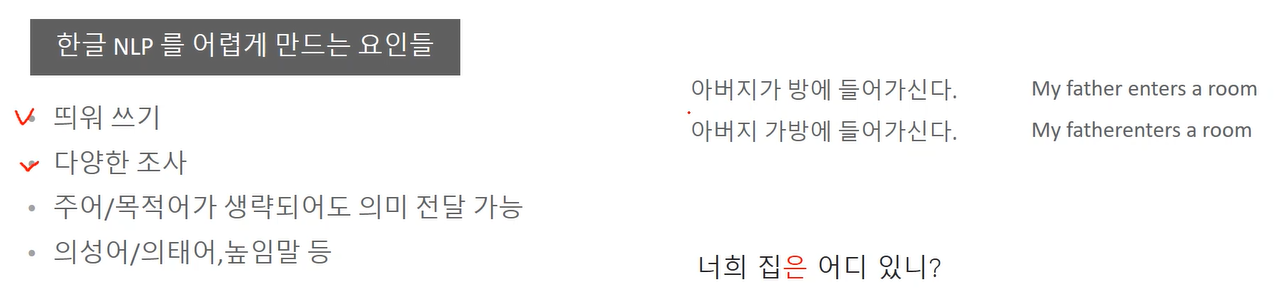

# 한글 형태소 분석
---
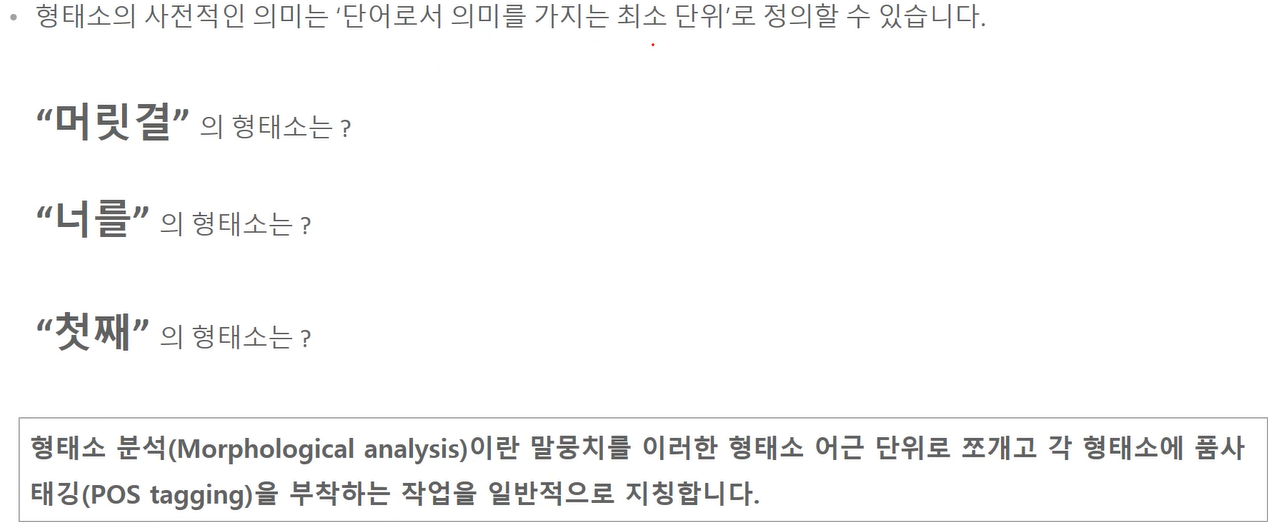

## KoNLPy
---
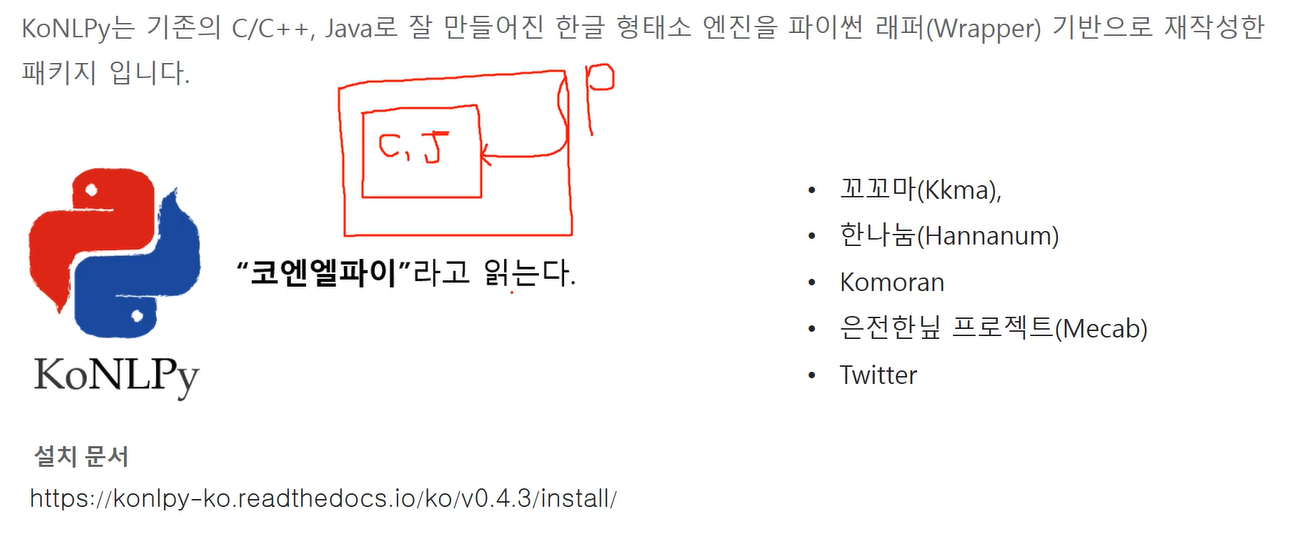

# 한글 NLP 실습 - 네이버 영화 리뷰 감성 분석
---

In [2]:
import pandas as pd

train_df = pd.read_csv('ratings_train.txt', sep='\t')
train_df.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0.0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1.0
2,10265843,너무재밓었다그래서보는것을추천한다,0.0


In [3]:
train_df['label'].value_counts()

0.0    15739
1.0    15634
Name: label, dtype: int64

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31374 entries, 0 to 31373
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        31374 non-null  int64  
 1   document  31373 non-null  object 
 2   label     31373 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 735.5+ KB


In [7]:
import re

train_df = train_df.fillna(' ')
# 정규 표현식을 이용하여 숫자를 공백으로 변경(정규 표현식으로 \d 는 숫자를 의미함.) 
train_df['document'] = train_df['document'].apply( lambda x : re.sub(r"\d+", " ", x) )

# 테스트 데이터 셋을 로딩하고 동일하게 Null 및 숫자를 공백으로 변환
test_df = pd.read_csv('ratings_test.txt', sep='\t')
test_df = test_df.fillna(' ')
test_df['document'] = test_df['document'].apply( lambda x : re.sub(r"\d+", " ", x) )

# 개정판 소스 코드 변경(2019.12.24)
train_df.drop('id', axis=1, inplace=True) 
test_df.drop('id', axis=1, inplace=True)


In [8]:
from konlpy.tag import Twitter

twitter = Twitter()
def tw_tokenizer(text):
    # 입력 인자로 들어온 text 를 형태소 단어로 토큰화 하여 list 객체 반환
    tokens_ko = twitter.morphs(text)
    return tokens_ko
tw_tokenizer('아빠가방에들어가신다')

C:\anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


['아빠', '가방', '에', '들어가신다']

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Twitter 객체의 morphs( ) 객체를 이용한 tokenizer를 사용. ngram_range는 (1,2) 
tfidf_vect = TfidfVectorizer(tokenizer=tw_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.9)
tfidf_vect.fit(train_df['document'])
tfidf_matrix_train = tfidf_vect.transform(train_df['document'])

C:\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [14]:
# Logistic Regression 을 이용하여 감성 분석 Classification 수행. 
lg_clf = LogisticRegression(random_state=0)

# Parameter C 최적화를 위해 GridSearchCV 를 이용. 
params = { 'C': [1 ,3.5, 4.5, 5.5, 10 ] }
grid_cv = GridSearchCV(lg_clf , param_grid=params , cv=3 ,scoring='accuracy', verbose=1 )
grid_cv.fit(tfidf_matrix_train , train_df['label'] )
print(grid_cv.best_params_ , round(grid_cv.best_score_,4))


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\67416\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\67416\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\67416\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1345, in fit
    check_classification_targets(y)
  File "C:\Users\67416\Anaconda3\lib\site-packages\sklearn\utils\multiclass.py", line 172, in check_classification_targets
    raise ValueError("Unknown label type: %r" % y_type)
ValueError: Unknown label type: 'unknown'

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished


ValueError: Unknown label type: 'unknown'

In [ ]:
from sklearn.metrics import accuracy_score

# 학습 데이터를 적용한 TfidfVectorizer를 이용하여 테스트 데이터를 TF-IDF 값으로 Feature 변환함. 
tfidf_matrix_test = tfidf_vect.transform(test_df['document'])

# classifier 는 GridSearchCV에서 최적 파라미터로 학습된 classifier를 그대로 이용
best_estimator = grid_cv.best_estimator_
preds = best_estimator.predict(tfidf_matrix_test)

print('Logistic Regression 정확도: ',accuracy_score(test_df['label'],preds))